### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `# YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. Never copy/paste any notebook cells. Inserting new cells is allowed, but it should not be necessary.
6. The notebook contains some hidden metadata which is important during our grading process. **Make sure not to corrupt any of this metadata!** The metadata may for example be corrupted if you copy/paste any notebook cells, or if you perform an unsuccessful git merge / git pull. 
7. If you need to have multiple parallel versions of this notebook, make sure not to move them to another directory.
8. Although not forced to work exclusively in the course `conda` environment, you need to make sure that the notebook will run in that environment, i.e. that you have not added any additional dependencies.

### Fill in group number and member names:

In [1]:
NAME1 = "Asma Raeisi" 
NAME2 = "Arturas Aleksandraus"
GROUP = "4"

### Check Python version

In [2]:
from platform import python_version_tuple
# assert python_version_tuple()[:2] == ('3','9'), "You are not running Python 3.9. Make sure to run Python through the course Conda environment."

# HA1 - Cats and dogs

<img src="https://cdn.pixabay.com/photo/2015/05/20/10/03/cat-and-dog-775116_960_720.jpg" alt="Image of cats and dogs" style="width: 500px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It is comprised of 25k colour images of dogs and cats. Our goal with this assignment will be to create a classifier that can discriminate between cats or dogs.

The goal is to make sure that you all can independently create, train and evaluate a model using a popular deep learning framework. A secondary goal is also to expose you to GPU computing, either your own or via a cloud computing service. The focus is on implementing the models, and much of the surrounding code is provided for you. You are expected to understand the provided code.

## Using your GPU

### Strong recommendation:
In order to make the most out of your GPU hours, first try solving the initial part of this notebook (tasks 0-3) in your own computer (these tasks can be solved on the CPU), and leave most of the available hours for solving tasks 4-5, and refining your best model further (and, if you have the spare hours, experiment a bit! (Task 6)).

### Working efficiently:
Training for several epochs just to have your code break at the last validation step is incredibly frustrating and inefficient. Good practice is to first test long training runs with a much simpler dry-run: a single epoch, a few batches et c.

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance. When experimenting, a single epoch is often enough to tell whether your model setup has improved or not.

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [3]:
from pathlib import Path
from random import randint
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as tf
import torch.optim as opt
import numpy as np

BATCH_SIZE=64
WORKERS=7
IMAGE_SIZE = 224
EPOCHS=10

---
## 1. Loading the data and preprocessing

In this part we will set up the data used in this assignment. You need to download it, then we'll walk you through how to make a custom Pytorch dataset abstraction. The abstraction enables you to visualise and play around with the image data and to finally create data loaders, which are necessary for the training.

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats/data) and download the data from there. You should download both the test and train folders together in one zip file (there is a `Download all` button at the bottom of the page). Unfortunately, you need to create a Kaggle account for this.

**Only necessary for tasks 4-6**: Downloading the data to your local computer is quite straight-forward. If you have to upload the data to a cloud/server instance that might be a bit more tricky. There are a few ways to do it:

 - Jupyter Notebook upload function. When starting the notebook server with the command `jupyter notebook` you are directed to a main page. In the top right corner there is an upload button.
 - Using [`scp`](https://linuxize.com/post/how-to-use-scp-command-to-securely-transfer-files/) to copy files via an ssh connection.
 - Using the [Kaggle CLI](https://github.com/Kaggle/kaggle-api). We have added it to the conda environment.

To begin with, download the data to your local computer and create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      cats        dogs       cats        dogs       cats        dogs       cats        dogs


The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`.
This is just a convenient way of having a smaller dataset to play with for faster prototyping.

We provide you a notebook that shows how to achieve this folder structure (`create_project_notebook_structure.ipynb`), starting from the original `dogs-vs-cats.zip` file that you download from Kaggle. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

**(2 points)**

For the smaller dataset, we advise you to use 70% of the data as training data (and thereby the remaining 30% for validation data). However, for the larger dataset, you should decide how to split between training and validation.

**What percentage of the larger dataset did you decide to use for training?**

**Did you decide to keep the same ratio split between train and validation sets for the larger dataset? Motivate your decision!**

**Your answer:** 70%/30% split is an industry standard which is a good baseline.

Fill in the dataset paths (to be used later by your data loaders):

In [4]:
# TODO: Change the directories accordingly
train_path = "./train"
test_path = "./test"
val_path = "./val"
all_path = "./train_all"
small_train_path = "./small_train/"
small_val_path = "./small_val"

### 1.1 Dataset

To create data loaders we first need to create a dataset abstraction class. The purpose of a data loader is to efficiently provide the CPU/GPU with mini-batches of data. We now work with data complex enough to actually warrant the use of data loaders. In particular, we don't want to load all images into memory at once.

The data loader is an instance of the Pytorch [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) which wraps a class that inherits from [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), that we create ourselves.
Image classification is such a common task that Pytorch provides a ready-to-use dataset class for this task, called [`ImageFolder`](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#imagefolder).
Using this class however, is rather opaque so for your understanding we will show you how to construct a custom dataset class. If you know this method, you will be able to create a data loader for any dataset you may encounter.

We construct a class `DogsCatsData` as a subclass of `Dataset`. 
The dataset subclass holds the actual data, or at least provides access to it.
To make it work with the `DataLoader` class we need to implement two methods:

- `__getitem__(self, index)`: return the `index`'th sample, i.e. a single pair of (image, label)
- `__len__(self)`: simply return the total number of samples $N$ in the dataset.

These methods are so called Python "magic" methods, signified by the leading and closing double underscores.
They typically enable special syntax for a class: `__getitem__` enables indexing of a class, and `__len__` enables calling the `len` function:
```python
# Consider an instance `data` of a class `MyDataset` implementing `__getitem__` and `__len__`
data[10] # returns the item with index 10 in `data`
len(data) # returns the length/size of `data`
```
We will return to why these are needed in the `DataLoader` wrapping class

Now, to the actual implementation: The idea is to have the dataset class only store the filenames of the images (and the corresponding label), not the images themselves. We will find and store the filenames in the constructor. The `__getitem__` method will use the index to look up the correct filename and load it into memory.
The `__len__` method is left for you to implement.

Being able to use and understand code you have not written is an important ability. Below you are required to interact with the dataset class with a simple completion of the implementation and by extracting some data from the class. This is partly to ensure that you understand this specific class and partly to show you some tools for exploring new code.

In [5]:
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image

class DogsCatsData(Dataset):
    
    def __init__(self, root, transform, dog_label=1, cat_label=0):
        """Constructor
        
        Args:
            root (Path/str): Filepath to the data root, e.g. './small_train'
            transform (Compose): A composition of image transforms, see below.
        """
        
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform = transform
        self._dog_label = dog_label
        self._cat_label = cat_label
        
        # Collect samples, both cat and dog and store pairs of (filepath, label) in a simple list.
        self._samples = self._collect_samples()
            
    def __getitem__(self, index):
        """Get sample by index
        
        Args:
            index (int)
        
        Returns:
             The index'th sample (Tensor, int)
        """
        # Access the stored path and label for the correct index
        path, label = self._samples[index]
        # Load the image into memory
        img = Image.open(path)
        # Perform transforms, if any.
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        """Total number of samples"""
        # YOUR CODE HERE
        N=len(self._samples)
        return N
    
    def _collect_samples(self):
        """Collect all paths and labels
        
        Helper method for the constructor
        """
        # Iterator over dog filpath
        dog_paths = self._collect_imgs_sub_dir(self.root / "dogs")
        # Iterator of pairs (path, dog label)
        # Again, we use the `map` function to create an iterator. It's use is not as common as the so called
        # 'list comprehension' you've previously seen, but a good alternative to have seen.
        dog_paths_and_labels = map(lambda path: (path, self._dog_label), dog_paths)
        # Same for cats
        cat_paths = self._collect_imgs_sub_dir(self.root / "cats")
        cat_paths_and_labels = map(lambda path: (path, self._cat_label), cat_paths)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(list(chain(dog_paths_and_labels, cat_paths_and_labels)), key=lambda x: x[0].stem)
     
    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory
        
        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")
    
    def get_sample_by_id(self, id_):
        """Get sample by image id
        
        Convenience method for exploration.
        The indices does not correspond to the image id's in the filenames.
        Here is a (rather inefficient) way of inspecting a specific image.
        
        Args:
            id_ (str): Image id, e.g. `dog.321`
        """
        id_index = [path.stem for (path, _) in self._samples].index(id_)
        return self[id_index]


**(2 points)**

Show that you understand the implementation by creating an instance called `example_dataset` of it. Create it from the small training set.
Use the instance to
 1. Print the number of samples in it
 2. Print the label of the second sample, note that this is a number (0 or 1)

In [6]:
# The Dataset constructor has a transform attribute, we will cover it below. Just use this for now:
from torchvision.transforms import Compose, ToTensor
transform = Compose([ToTensor()])

example_dataset=DogsCatsData(train_path,transform)
img, lable = example_dataset[0]
print(lable)
print(img.shape)


0
torch.Size([3, 374, 500])


It is vital to explore your data, but it can be tricky to deal with images in the tensor format.
To aid you, use the below helper function to visually inspect your images.

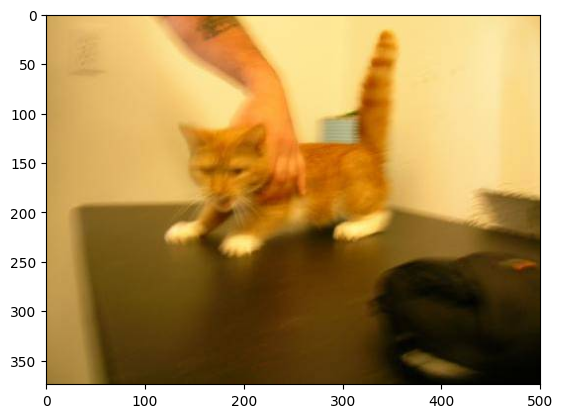

In [7]:
def display_image(axis, image_tensor):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)

# Example usage
_, axis = plt.subplots()
some_random_index = 0
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
image_tensor, label = example_dataset[some_random_index]
display_image(axis, image_tensor)

### 1.2 Preprocessing 
The `DogsCatsData` class constructor has an argument called `transform`. It allows us to transform or preprocess all the images in a batch, from the raw image data to a more suitable format. There are multiple motivations for preprocessing:

- Some transformations might be needed to actually make the data work with our network (reshaping, permuting dimensions et c.).
- Make the training more efficient by making the input dimensions smaller, e.g. resizing, cropping.
- Artificially expanding the training data through [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/)
- We have some clever idea of how to change the data to create a simpler optimisation problem.

We do not expect you to do data augmentation, but feel free to preprocess the data as you see fit. Use the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision-transforms) to view available transforms. Extra important is the `Compose` transformation, which is a meta-transformation which composes actual ones, and the `ToTensor` transformation which is the simplest way to go from image to tensor format.


Hints:
- Revisit the `DogsCatsData` example usage to see how to use the `Compose` and `ToTensor` transformations.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned Pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial as it speeds up training. The CNN's do surprisingly well on 64x64 or even 32x32 images. Shorter training cycles give you more time to experiment! Note: The VGG network used later in this assignment is specialised for images that are 224x224.

We encourage you to explore the data and choose transformations that you believe to be useful. For exploration we provide you with a helper function to visually compare transformations side by side:

In [8]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of DogsCatsData datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.
    
    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)
    
    Args:
        transformations (list(DogsCatsData)): list of dataset instances with different transformations
        index (int): Index of the sample in the dataset you wish to compare.
    """

    # Here we combine two functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, e.g. a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError("All elements in the `transformations` list need to be of type Dataset")
        
    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)
    
    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]
        
    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title(f"transf: {counter}")
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

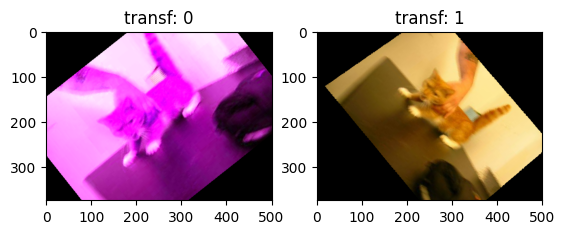

In [9]:
# Explore your dataset in this cell, you do not need to produce any results.
transform1= Compose([tf.ColorJitter(brightness=.5, hue=.3),tf.RandomAffine(90), tf.RandomAutocontrast(.5),ToTensor()])

transform2= Compose([tf.RandomPerspective(.5),tf.RandomRotation(90),tf.RandomSolarize(.5),ToTensor() ])

example_dataset1=DogsCatsData(train_path,transform1)
example_dataset2=DogsCatsData(train_path,transform2)

compare_transforms([example_dataset1,example_dataset2], 0)


**(2 points)**

Normalisation of the training data is popular in pre-processing. What is the argument or intuition for why this is a beneficial transformation?

**Your answer:** It is used for numerical stability to make sure that all the input data is within the same range.

### 1.3 Data loaders
With our dataset class implementation in place, creating a `DataLoader` instance is simple.

The data loader class wraps the dataset and provides a way to iterate over batches in the training loop.
To produce batches, it gets the total number of samples $N$ with the dataset's `__len__` method.
It divides the indices $1, \dots, N$ into equally sized index batches with $B$ (batch size) elements. A particular batch with pairs of image and label is created by calling the dataset's `__getitem__` method with the indices in the batch. NB: the last batch in an epoch might be smaller if $N$ is not divisible by $B$.

Create the data loaders needed for training (use the small version of the data), in the cell below.
The `DataLoader` class is documented [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) , but it's not that much to it.
You simply create a data loader with a dataset instance and some other (self-explanatory) settings:

```python
train_dataloader = DataLoader(example_dataset, batch_size=batch_size, shuffle=True)
```

**(1 point)**

Create data loaders required for training and validation.

Hints:
- The specified `batch_size` should be chosen so that you train fast but don't run out of memory. You need to figure this out empirically; start small and increase the batch size until you run out of memory. Beyond this pragmatic approach, feel free to contribute to the highly contested scientific debate about the relation between batch size and generalisation.
- The `DataLoader` constructor takes an optional argument `num_workers`, which defaults to `0` if not provided. Setting a higher number creates multiple threads which load batches concurrently. This can speed up training considerably.

In [10]:
transform = Compose([tf.Resize((IMAGE_SIZE, IMAGE_SIZE)),tf.ToTensor(),tf.Normalize(mean=[0, 0, 0], std=[1, 1, 1])])

dl_small_train = DataLoader(DogsCatsData(small_train_path, transform), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=WORKERS)
dl_small_val = DataLoader(DogsCatsData(small_val_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)


---
## 2. Training

### 2.1 The first model

**(3 points)**

Now, it's time to create a model called `FirstCnn`. To begin with, you have to create a CNN to an exact specification. After that, you will get the chance to be more creative.

For the first model, create a network that:
- Inherits from [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)
- Implements a constructor `__init__(self, img_size)`, a `forward(self, input_batch)` method and whatever other helper methods you deem necessary. Note that a (square) image size should be a parameter in the model's constructor. While not strictly necessary, it is an acceptable way of handling varying input dim's and it is convenient for testing.
- Can handle square images of arbitrary size and arbitrary large mini-batch sizes (within memory limits, of course). You may assume that there are always three colour channels, i.e., a mini-batch will have the shape `(batch size = B, num channels = 3, img size = D, D)`
- Has layers:
    1. Two convolutional layers, each with 10 filters, kernel size = 3, stride = 1, padding = 0
    2. A single fully connected layer.
- Related layers such as a pooling operation are optional.
- Choose suitable activation functions
- Outputs the probability of the image belonging to the class 'dog'. Technically the output should consist of `B` probabilities, one for each image in the mini-batch and so have the shape `(B,)`.

Hints:

- The subpage for [`torch.nn`](https://pytorch.org/docs/stable/nn.html) is a good place to find the layer specifics.
- Going from the last CNN layer to the final fully connected layer is not trivial. The convolutions produces feature maps which we can think of as an image with many channels, while the fully connected layer expects a row vector as input. Calculate how many output neurons the convolutions produce and use `.reshape` to make your tensor fit the fully connected layer. It is also common to see the `.view` and `.squeeze` methods to do the same thing. They basically do the same thing (apart from some differences in internal memory management) but are less transparent. *Hint within the hint:* remember that the fully connected layers expects a *batch* of 1D tensors. 


In [11]:
# YOUR CODE HERE
def conImgSize(img_size,k,s,p):
    o=int((img_size+(2*p)-k)/s)+1 # needed to change to int, it was float 
    return o


class FirstCnn(nn.Module):
    def __init__(self,img_size,filter=10,k=3,s=1,p=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, filter, k,s,p)
        self.conv2 = nn.Conv2d(filter, filter, k,s,p)

        self.activation=nn.ReLU()

        s1=conImgSize(img_size,k,s,p)
        s2=conImgSize(s1,k,s,p)

        self.classifier=nn.Linear(s2*s2*filter,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, image):
        out1 = self.conv1(image)
        relo1=self.activation(out1)
        out2 = self.conv2(relo1)
        relo2=self.activation(out2)
        vector=torch.flatten(relo2, start_dim=1)
        classOut=self.classifier(vector)
        return self.sigmoid(classOut).view(-1)



In [12]:
def test_model(model_class):
    assert issubclass(model_class, nn.Module), "Model class should inherit from nn.Module"
    
    assert getattr(model_class, "forward", None) is not None, "Model class should have a 'forward' method"
    
    _test_output(model_class, some_img_size=224, some_batch_size=64)
    _test_output(model_class, some_img_size=32, some_batch_size=8)
    
    print("Test passed.")

def _test_output(model_class, some_img_size, some_batch_size):
    random_input = torch.rand(some_batch_size, 3, some_img_size, some_img_size)
    model_instance = model_class(img_size=some_img_size)
    output = model_instance.forward(random_input)
    output_shape = list(output.shape)
    assert output_shape == [some_batch_size], f"Expected output size [{some_batch_size}], got {output_shape}"
    
# Note that the test takes the actual class, not an instance of it, as input.
# Here, we assume that the model class is named 'FirstCnn'
test_model(FirstCnn)

Test passed.


**(3 points)**

You have been told that one of the benefits of CNN is that it can handle input of different sizes. Yet, you needed to know the image size in the constructor.
Explain how you made your model handle different input sizes and why it is necessary, despite it being a CNN.

**Your answer:** In the FirstCnn class we specify the size of input image as a pharameter. so, it can get images of any sizes.However, at the last layer we should know the exact size of input. So, in order to solve the problem we pharameterize the input size and calculate the size of input at the last layer.

### 2.2 The training loop

**(1 point)**

You might already have seen quite a few training loops in the preparations (if not, check the computer labs and the optional individual home assignments). Below we provide you with an example of a basic one that you can use.
You need to provide an implementation that maps network outputs (probabilites) to hard labels.

An extra point is awarded if you provide a vectorised implementation.

In [13]:
def output_to_label(z, threshold=0.5):
    """Map network output z to a hard label {0, 1}
    
    Args:
        z (Tensor): Probabilities for each sample in a batch.
    Returns:
        c (Tensor): Hard label {0, 1} for each sample in a batch
    """
    return (z>threshold).type(torch.long)


def test_output_to_label(fn):
    batch_size = torch.randint(1, 64, (1,))
    random_logits = torch.rand(batch_size)
    random_probs = random_logits / random_logits.sum()
    labels = fn(random_probs)
    assert labels.shape == random_logits.shape, "The element-wise function should preserve the shape"
    assert labels.dtype == torch.long, "Incorrect datatype, should be torch.long"
    fixed_logits = torch.tensor([0.1, 0.9, 0.51, 0.49, 0.7])
    fixed_labels = torch.tensor([0, 1, 1, 0, 1], dtype=torch.long)
    assert all(fixed_labels == fn(fixed_logits)), "Incorrect fixed output"
    assert fixed_logits.device == fixed_labels.device, "Make sure to specify tensor device" # <- Pseudo code for device unit test
    print("Test passed!")

test_output_to_label(output_to_label)

Test passed!


In [14]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

**(1 point)**

Use the training loop to train your model, using the two data loaders you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Hints:
- Training on a CPU is slow and in the beginning you just want to verify that your architecture actually produces a predicition with the correct shape. Make everything you can to speed up the prototyping phase, e.g. train only for a single epoch and make the images ridiculously small.

In [ ]:
model = FirstCnn(img_size=224,filter=10,k=3,s=1,p=0)
optimizer = opt.Adam(model.parameters(), lr=1e-4) #1e-3 - 1e-5
loss_fn = nn.BCELoss()

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, dl_small_train, dl_small_val, EPOCHS, 25)

### 2.3 Visualisation

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.
Note that the given training loop produces metrics at different intervals for training and validation, make sure that you align your metrics in a way that makes sense.

In [15]:
def plot(data):
    max_items = max(map(lambda x: len(x[0]), data))
    fig, ax = plt.subplots()
    for d, name in data:
        x = np.linspace(0, max_items, len(d))
        ax.plot(x, d, label = name)
    ax.grid()
    ax.set_xlabel("Number of optimization steps")
    ax.set_ylabel("Score")

    fig.legend()
    fig.show()

In [24]:
plot([(train_accs, "train_acc"), (val_accs, "val_acc")])

NameError: name 'train_accs' is not defined

In [ ]:
plot([(train_losses, "train_loss"), (val_losses, "val_loss")])

**(2 points)**

Based on these, what would you suggest for improving your model? Why?

**Your answer:** It seems that our model has high bias and low variance. So, to solve the problem we could use a bigger network.

---
## 3. Improving your model

**(3 points)**

Now you are free to create whichever model you want. A simple improvement based on your analysis of the above results is fine, or you can do something more ambitious. When you're happy with one architecture, copy it in the cell below and train it here. Save the training and validation losses and accuracies. You'll use this later to compare your best model with the one using transfer learning.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to Canvas, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [ ]:
class ImprovedCnn(nn.Module):
    def __init__(self,img_size,filter=10,k=3,s=1,p=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, filter, k,s,p)
        s1=conImgSize(img_size,k,s,p)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 
        s2=conImgSize(s1,2,2,0)
         
        self.conv2 = nn.Conv2d(filter, filter*2, k,s,p)
        s3=conImgSize(s2,k,s,p)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 
        s4=conImgSize(s3,2,2,0)

        self.conv3 = nn.Conv2d(filter*2, filter*4, k,s,p)
        s5=conImgSize(s4,k,s,p)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 
        s6=conImgSize(s5,2,2,0)

        self.conv4 = nn.Conv2d(filter*4, filter*8, k,s,p)
        s7=conImgSize(s6,k,s,p)


        self.classifier=nn.Linear(s7*s7*filter*8,1)
        self.activation=nn.ReLU()
        self.sigmoid=nn.Sigmoid()



    def forward(self, image):
        out1 = self.conv1(image)
        relo1=self.activation(out1)
        p1=self.pool1(relo1)

        out2 = self.conv2(p1)
        relo2=self.activation(out2)
        p2=self.pool2(relo2)

        out3 = self.conv3(p2)
        relo3=self.activation(out3)
        p3=self.pool3(relo3)

        out4 = self.conv4(p3)
        relo4=self.activation(out4)

        vector=torch.flatten(relo4, start_dim=1)
        classOut=self.classifier(vector)
        return self.sigmoid(classOut).view(-1)
        

In [ ]:
model = ImprovedCnn(img_size=224,filter=10,k=3,s=1,p=0)
optimizer = opt.Adam(model.parameters(), lr=1e-4) #1e-3 - 1e-5
loss_fn = nn.BCELoss()

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, dl_small_train, dl_small_val, EPOCHS, 25)

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

In [ ]:
plot([(train_accs, "train_acc"), (val_accs, "val_acc")])

In [ ]:
plot([(train_losses, "train_loss"), (val_losses, "val_loss")])

**(3 points)**

Did your results improve? What problems did your improvements fix? Explain why, or why not. 

**Your answer:** We made a bigger network by adding more layers, more filters, and pooling layers.

But it still suffers from the problem of high bias. So, we need to make it bigger.

[Save your model](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to disk (the architecture, weights and optimizer state). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual file you create is not relevant to your submission. The code to save the model is given in the cell below. 

In [ ]:
# Assuming that you named your model "improved_model"
torch.save(model.state_dict(), "imp_model.pkl")
# Create and initialise model with a previously saved state dict:
saved_model = ImprovedCnn(img_size=224)
saved_model.load_state_dict(torch.load("imp_model.pkl"))

---
## 4. Transfer Learning

**From now, training on a CPU will likely not be feasible. If your computer has a GPU, try it out! Otherwise, now is the time to connect to a cloud/server instance**

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected layers + softmax). We'll substitute them with our own top network, designed for dog/cat classification.
This top network is often called the "head" in transfer learning.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the *pretrained* VGG16 model, from the [torchvision.models](https://pytorch.org/vision/stable/models.html?highlight=vgg#torchvision.models.vgg16).

In [ ]:
from torchvision import models
vgg_model = models.vgg16(pretrained=True)
print(vgg_model)

**(1 point)**

Create a new model as a so-called head network to the base VGG model.
VGG is a relatively deep network so think about what would be a reasonable model head for transfer learning.

*Hint:*
- You can access and modify the top layers of the VGG model with `vgg_model.classifier`, and the remaining layers with `vgg_model.features`.
- You can get the number of output features of `vgg_model.features` with `vgg_model.classifier[0].in_features`

In [ ]:
linear_size = vgg_model.classifier[0].in_features
linear_size

**(2 points)**

Now add the new model on top of VGG.

In [ ]:
vgg_model.classifier = nn.Sequential(
            nn.Linear(linear_size, 1),
            nn.Sigmoid(),
            nn.Flatten(start_dim=0),
        )
vgg_model

### 4.1 Using VGG features

**(1 point)**

Now we're almost ready to train the new model. For transfer learning we want to freeze all but the top layers in your architecture (i.e. signal to the optimizer that the bottom layers should not be changed during optimization) by setting the attribute `requires_grad` for all parameters `vgg_model.features` to `False`.

In [ ]:
for param in vgg_model.features.parameters():
    param.requires_grad = False
for param in vgg_model.classifier.parameters():
    param.requires_grad = True


**(1 point)**

Perform the transfer learning by training the top layers of your model.

In [ ]:
optimizer=opt.Adam(vgg_model.parameters(), lr=1e-4, weight_decay=0)
loss_fn = nn.BCELoss()

transform = Compose([tf.Resize((IMAGE_SIZE, IMAGE_SIZE)),tf.ToTensor(),tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

vgg_dl_small_train = DataLoader(DogsCatsData(small_train_path, transform), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=WORKERS)
vgg_dl_train = DataLoader(DogsCatsData(train_path, transform), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=WORKERS)

vgg_dl_small_val = DataLoader(DogsCatsData(small_val_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
vgg_dl_val = DataLoader(DogsCatsData(val_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

vgg_model, vgg_train_losses, vgg_train_accs, vgg_val_losses, vgg_val_accs = training_loop(vgg_model, optimizer, loss_fn, vgg_dl_small_train, vgg_dl_small_val, EPOCHS, 25)

**(1 point)**

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

In [ ]:
plot([(vgg_train_accs, "vgg_train_accs"), (vgg_val_accs, "vgg_val_accs")])

In [ ]:
plot([(vgg_train_losses, "vgg_train_losses"), (vgg_val_losses, "vgg_val_losses")])

**(2 points)**

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
plot([(val_accs, "train_accs"), (vgg_val_accs, "vgg_train_accs")])

In [ ]:
plot([(val_losses, "val_losses"), (vgg_val_losses, "vgg_val_losses")])

**(3 points)**

Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Reflect on whether your comparison is fair or not:

**Your answer:** As results show, using transfer learning will lead to much better performance. One of the reasons is that we do not start from random weights but have a collection of filters that are already good at catching semantically useful features. Thus by only training the top part of the model we can map what features are important for this domain. We might not always be able to retain a model from scratch is we lack data. Hence, this is a better starting ground. In addition,our network has a high bias so, using a bigger network solved the problem but there is always a risk of overfitting with more flexible models. 

**(2 points)**

What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** ImageNet consists of 1000 classes where cats and dogs are a subset of the data. Dogs vs Cat dataset is smaller with a narrower domain. 

**(2 points)**

Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** When we use transfer learning, we can use the knowledge learned from a bigger and large domain with features that are transferable to this smaller and more specific domain. This is not always the case.

**(1 point)**

In which scenario would transfer learning be unsuitable?

**Your answer:** Where the empirical evidence shows a bad performance. This is not always easy to say since it works surprisingly well even though the domain shift is large. But, if we want to use a different model architecture that does not have pretained weight then is more difficult ;P 

Save the model to a file.

In [ ]:
torch.save(vgg_model.state_dict(), "transferred_vgg_model.pkl")

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers by resetting the `requires_grad` attribute to `True`.

In [ ]:
vgg_model.load_state_dict(torch.load("transferred_vgg_model.pkl"))
for param in vgg_model.parameters():
    param.requires_grad = True

**(1 point)**

Fine tune the model by training all the layers.

In [ ]:
optimizer=opt.Adam(vgg_model.parameters(), lr=1e-5, weight_decay=0)
loss_fn = nn.BCELoss()

vgg_model, fine_vgg_train_losses, fine_vgg_train_accs, fine_vgg_val_losses, fine_vgg_val_accs = training_loop(vgg_model, optimizer, loss_fn, vgg_dl_small_train, vgg_dl_small_val, EPOCHS, 25)

**(1 point)**

How does the model perform, compared to the model trained with frozen layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
plot([(vgg_train_accs, "vgg_train_accs"), (fine_vgg_train_accs, "fine_vgg_train_accs")])

In [ ]:
plot([(vgg_val_accs, "vgg_val_accs"), (fine_vgg_val_accs, "fine_vgg_val_accs")])

**(2 points)**

Why is it a good idea to use a very small learning rate when doing fine tuning?

**Your answer:** Since we are using a pre-trained model so, it means that we are close to a local minimum. Therefore, if we use a big learning rate we could jump out of it.

Save the model to file.

In [ ]:
torch.save(vgg_model.state_dict(), "fine_tuned_vgg_model.pkl")

### 4.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here.

In [ ]:
class DogCatModel(nn.Module):
    def __init__(self, weights=models.VGG16_Weights.IMAGENET1K_V1) -> None:
        super().__init__()
        self.model = models.vgg16(weights=weights)
        self.model.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.model.classifier = nn.Sequential(
                    nn.Linear(512*3*3, 4096),
                    nn.BatchNorm1d(4096),
                    nn.ReLU(True),
                    nn.Linear(4096, 1),
                    nn.Sigmoid(),
                    )
    def forward(self, x):
        x = self.model.features(x)
        x = self.model.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.model.classifier(x)
        return x.view(-1)
    
dc_model = DogCatModel()
optimizer=opt.Adam(dc_model.parameters(), lr=1e-5, weight_decay=0)
loss_fn = nn.BCELoss()

dc_model, dc_train_losses, dc_train_accs, dc_val_losses, dc_val_accs = training_loop(dc_model, optimizer, loss_fn, vgg_dl_small_train, vgg_dl_small_val, EPOCHS, 25)

**(1 point)**

How does the model perform, compared to the model trained in step 4.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
plot([ (fine_vgg_val_accs, "fine_vgg_val_accs"), (dc_val_accs, "dc_val_accs")])

In [ ]:
plot([ (fine_vgg_train_accs, "fine_vgg_train_accs"), (dc_train_accs, "dc_train_accs")])

Save the model to a file.

In [ ]:
torch.save(dc_model.state_dict(), "dc_model.pkl")

## 5. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data loaders, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [ ]:
transform = Compose([tf.Resize((IMAGE_SIZE, IMAGE_SIZE)),tf.ToTensor(),tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dl_train = DataLoader(DogsCatsData(small_train_path, transform), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=WORKERS)
dl_val = DataLoader(DogsCatsData(val_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

**(1 point)**

Train your model using the full data. This optimization might take a long time.

In [ ]:
final_vgg_model = models.vgg16(pretrained=True)
linear_size = vgg_model.classifier[0].in_features
final_vgg_model.classifier = nn.Sequential(
            nn.Linear(linear_size, 1),
            nn.Sigmoid(),
            nn.Flatten(start_dim=0),
        )

final_vgg_model.load_state_dict(torch.load("fine_tuned_vgg_model.pkl"))

optimizer = opt.Adam(final_vgg_model.parameters(), lr=1e-4) #1e-3 - 1e-5
loss_fn = nn.BCELoss()

final_vgg_model, final_vgg_train_losses, final_vgg_train_accs, final_vgg_val_losses, final_vgg_val_accs = training_loop(final_vgg_model, optimizer, loss_fn, dl_train, dl_val, EPOCHS, 25)

**(1 point)**

How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
plot([(final_vgg_train_accs, "final_vgg_train_accs"), (fine_vgg_train_accs, "fine_vgg_train_accs")])

In [ ]:
plot([(final_vgg_val_accs, "final_vgg_val_accs"), (fine_vgg_val_accs, "fine_vgg_val_accs")])

**(2 points)**

What can you conclude from these plots? Did you expect what you observe in the plots, explain!

**Your answer:** From the plots we can see the performance of how the model trained on the large data preforms on the large validation data and how the model that is trained using the small training data preforms on the small validation data. But, since they are not using the same data when computing the accuracy score we can not confidently compare there results. However, for this simple domain the result might be representable.      

## 6. Evaluation on test set (optional)

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labelled, so we can't compute any supervised performance metrics ourselves. 

As a bit of fun and to inspire some friendly competition you may instead submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

For the test data we need a slightly different dataset class, due to the lack of labels in the data.
A more proper way to implement it would be to make a common class which handles both the train and test settings.
Here, we'll just copy the train dataset class and make some modifications to ignore the labels.

Hints:
- There is a `sampleSubmission.csv` file included in the zip data. Take a look at it to better understand what is the expected format here.
- If you don't know how to create and write to files with Python, it's a well-behaved Google search.

In [15]:
from pathlib import Path
from PIL import Image
from time import time

class TestData(Dataset):
    
    def __init__(self, root: Path, transform):
        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")
            
        self.root = root
        self.transform = transform
        self._samples = self._collect_samples()
            
    def __getitem__(self, index):
        path = self._samples[index]
        num_id = int(path.stem)
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img) 
        return img, num_id
    
    def __len__(self):
        return len(self._samples)
    
    def _collect_samples(self):
        test_paths = self._collect_imgs_sub_dir(self.root)
        return sorted(list(test_paths), key=lambda path: int(path.stem))
     
    def _collect_imgs_sub_dir(self, sub_dir: Path):
        if not sub_dir.exists():
            raise ValueError(f"Data root '{self.root}' must contain sub dir '{sub_dir.name}'")
        return sub_dir.glob("*.jpg")
    
    def get_sample_by_id(self, id_):
        id_index = self._samples.index(id_)
        return self[id_index]



In [16]:
randomChoice = tf.RandomChoice([
        tf.ColorJitter(brightness=.5, hue=.3),
        tf.ElasticTransform(), 
        tf.GaussianBlur(5), 
        tf.RandomAdjustSharpness(1), 
        tf.RandomAffine(90), 
        tf.RandomAutocontrast(.5), 
        tf.RandomErasing(.5), 
        tf.RandomHorizontalFlip(.5), 
        tf.RandomInvert(.5), 
        # tf.RandomPerspective(.5), 
        tf.RandomRotation(90), 
        # tf.RandomSolarize(.5), 
        tf.RandomVerticalFlip(.5),
    ])
transform = tf.Compose([ 
    tf.Resize((int(IMAGE_SIZE*1.2), int(IMAGE_SIZE*1.2))),
    # tf.RandomApply([
    #     tf.RandomEqualize(),
    #     tf.RandomPosterize(bits=2), 
    # ]), 
    tf.ToTensor(),
    randomChoice, 
    randomChoice, 
    randomChoice, 
    tf.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE)), 
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_val = Compose([
    tf.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    tf.ToTensor(), 
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

dl_train = DataLoader(DogsCatsData(train_path, transform), batch_size=32, shuffle=True, drop_last=True, num_workers=WORKERS)
dl_train_no_aug = DataLoader(DogsCatsData(train_path, transform_val), batch_size=32, shuffle=True, drop_last=True, num_workers=WORKERS)
dl_val = DataLoader(DogsCatsData(val_path, transform_val), batch_size=32, shuffle=False, drop_last=True, num_workers=WORKERS)


In [17]:
from torchvision import models

In [29]:
test_model = models.vit_l_32(weights=models.ViT_L_32_Weights.IMAGENET1K_V1)
linear_size = test_model.heads.head.in_features
test_model.heads = nn.Sequential(
            nn.Linear(linear_size, 1),
            nn.Sigmoid(),
            nn.Flatten(start_dim=0),
        )
for param in test_model.parameters():
    param.requires_grad = False
for param in test_model.heads.parameters():
    param.requires_grad = True

In [38]:
test_model = models.wide_resnet101_2(weights=models.Wide_ResNet101_2_Weights.IMAGENET1K_V2)
linear_size = test_model.fc.in_features
test_model.fc = nn.Sequential(
            nn.Linear(linear_size, 1),
            nn.Sigmoid(),
            nn.Flatten(start_dim=0),
        )
for param in test_model.parameters():
    param.requires_grad = False
for param in test_model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-d733dc28.pth" to /home/arty/.cache/torch/hub/checkpoints/wide_resnet101_2-d733dc28.pth
100.0%


In [18]:
test_model = models.resnext101_64x4d(weights=models.ResNeXt101_64X4D_Weights.IMAGENET1K_V1)
linear_size = test_model.fc.in_features
test_model.fc = nn.Sequential(
            nn.Linear(linear_size, 1),
            nn.Sigmoid(),
            nn.Flatten(start_dim=0),
        )
for param in test_model.parameters():
    param.requires_grad = False
for param in test_model.fc.parameters():
    param.requires_grad = True

In [36]:
test_model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
linear_size = test_model.fc.in_features
test_model.fc = nn.Sequential(
            nn.Linear(linear_size, 1),
            nn.Sigmoid(),
            nn.Flatten(start_dim=0),
        )
for param in test_model.parameters():
    param.requires_grad = False
for param in test_model.fc.parameters():
    param.requires_grad = True

In [39]:
test_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [40]:
optimizer = opt.Adam(test_model.parameters(), lr=1e-5) #1e-3 - 1e-5
loss_fn = nn.BCELoss()

In [41]:

_ = training_loop(test_model, optimizer, loss_fn, dl_train, dl_val, 3, None)

Starting training
Epoch 1/3: Train loss: 0.654, Train acc.: 0.669, Val. loss: 0.591, Val. acc.: 0.897
Epoch 2/3: Train loss: 0.586, Train acc.: 0.818, Val. loss: 0.508, Val. acc.: 0.953
Epoch 3/3: Train loss: 0.530, Train acc.: 0.852, Val. loss: 0.437, Val. acc.: 0.969


In [44]:
# optimizer.zero_grad()
for param in test_model.parameters():
    param.requires_grad = True
# optimizer = opt.Adam(test_model.parameters(), lr=1e-5) #1e-3 - 1e-5

In [45]:
_ = training_loop(test_model, optimizer, loss_fn, dl_train, dl_val, 1, None)

Starting training
Epoch 1/1: Train loss: 0.189, Train acc.: 0.929, Val. loss: 0.020, Val. acc.: 0.996


In [49]:
_ = training_loop(test_model, optimizer, loss_fn, dl_train_no_aug, dl_val, 1, None)

Starting training
Epoch 1/1: Train loss: 0.012, Train acc.: 0.996, Val. loss: 0.009, Val. acc.: 0.997


In [50]:
transform = Compose([tf.Resize((IMAGE_SIZE, IMAGE_SIZE)),tf.ToTensor(),tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dl_test = DataLoader(TestData(test_path, transform), batch_size=32, num_workers=4)
ans = []
with torch.no_grad():
    for xs, ids in dl_test:
        x = xs.to("cuda:0")
        preds = test_model(x)
        y_hats = output_to_label(preds)
        ans.extend(list(zip(ids,y_hats)))

with open("submission_asma_arty_wide_resnet_fft_997.csv", "w") as f:
    f.write("id,label\n" + "\n".join([f"{i},{l}" for i, l in ans]))



Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, but you can submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) via the "Late submission" button (they use the same data). The Kaggle CLI can be used as well. Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** 0.1652

What was the username you used for this submission?

**Your answer:** Arturas Aleksandraus